In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorpac.utils import PSD

In [4]:
class subject:
    sf=160;
    montage = mne.channels.make_standard_montage('standard_1020')
    ch_map = {'Fc5': 'FC5',
              'Fc3': 'FC3',
              'Fc1': 'FC1',
              'Fcz': 'FCz',
              'Fc2': 'FC2',
              'Fc4': 'FC4',
              'Fc6': 'FC6',
              'Cp5': 'CP5',
              'Cp3': 'CP3',
              'Cp1': 'CP1',
              'Cpz': 'CPz',
              'Cp2': 'CP2',
              'Cp4': 'CP4',
              'Cp6': 'CP6',
              'Af7': 'AF7',
              'Af3': 'AF3',
              'Afz': 'AFz',
              'Af4': 'AF4',
              'Af8': 'AF8',
              'Ft7': 'FT7',
              'Ft8': 'FT8',
              'Tp7': 'TP7',
              'Tp8': 'TP8',
              'Po7': 'PO7',
              'Po3': 'PO3',
              'Poz': 'POz',
              'Po4': 'PO4',
              'Po8': 'PO8'}
    
    def __init__(self,sbj,rec):
        self.edf_loc = '/media/biraj/DATA/Motor Imagery Dataset/S'+sbj+'/S'+sbj+'R'+rec+'.edf'
        self.data = mne.io.read_raw_edf(self.edf_loc, preload = True)
        self.data.rename_channels(lambda x: x.strip('.'))
        self.data.rename_channels(self.ch_map)
        self.data.set_montage(self.montage)
        #self.include ={'Fp1', 'Fp2','AF3','AF4','AF7','AF8',
        #              'FC1','FC2','FC3','FC4','FC5','FC6',
        #              'C1','C2','C3','C4','C5','C6',
        #              'CP1','CP2','CP3','CP4','CP5','CP6'}
        #self.picks=mne.pick_channels(self.data.ch_names, self.include, ordered=True)
        #self.data = self.data.pick_channels(self.include)
        #self.data.save('sample_raw.fif', tmin=0, tmax=2*60*60, picks=self.picks,overwrite=True)
        self.events, self.event_id = mne.events_from_annotations(self.data)
        self.epochs = mne.Epochs(self.data, self.events, self.event_id, baseline=(None,None))
        self.info = self.data.info
       
        
    def filter_data(self):
        ch_names = self.data.ch_names
        info = mne.create_info(self.data.ch_names, sfreq= self.sf,ch_types='eeg')
        self.data.plot_psd()
        arr = mne.filter.notch_filter(self.data.get_data(), Fs=self.sf, freqs = 60)
        self.data = mne.io.RawArray(arr, info)
        self.data.set_montage(self.montage)
        self.data = self.data.pick_channels(self.include)
        self.data.plot_psd()
        return self.data
        
    def band_pass_filter(self, d, l_freq, h_freq):
        self.iir_params = dict(order=4, ftype='butter', output='sos') 
        self.d = d;
        self.l_freq = l_freq
        self.h_freq = h_freq
        self.d.filter(l_freq = self.l_freq, h_freq = self.h_freq,method = 'iir', iir_params = self.iir_params)
        return d
        

    def segment_epochs(self, received_data):
        ### for the purpose of segmenting the data into T0 T1/T2 T0 format so as to include two resting period
        ### before and after the movement task
        self.received_data = received_data
        self.onset = []
        self.duration = 2
        self.description = []

        for i in range(len(self.events)-1):
            if self.events[i, 2] == 1:
                continue
            elif self.events[i, 2] == 2:
                print(self.events[i][0])
                self.onset.append(self.events[i][0])
                #self.duration.append(self.events[i][0]-2)
                self.description.append('T1')
                continue
            elif self.events[i, 2] == 3:
                print(self.events[i][0])
                self.onset.append(self.events[i][0])
                #self.duration.append(self.events[i][0]-2)
                self.description.append('T2')
                continue
        self.onset = np.array(self.onset)/160
        #self.duration = np.array(self.duration)/160
        self.my_ann = mne.Annotations(self.onset, self.duration, self.description)
        self.received_data.set_annotations(self.my_ann)
        self.events, self.event_id=mne.events_from_annotations(self.received_data)
        self.epochs=mne.Epochs(self.received_data, self.events, event_id=self.event_id, tmin=0, tmax=2, baseline=(None,None))
        return self.epochs

    def calc_connectivity(self, received):
        self.fmin=0.5
        self.fmax=4
        
        self.how_many = 2
        self.eeg_data = received
        print('ok')
        plv, freqs, times, n_epochs, n_tapers=mne.connectivity.spectral_connectivity(self.epochs,method='plv', 
                                                indices=None, mode='cwt_morlet', sfreq=self.info['sfreq'], 
                                                fmin=self.fmin, fmax=self.fmax, faverage=True, 
                                                cwt_freqs=np.linspace(self.fmin,self.fmax,self.how_many), 
                                                cwt_n_cycles=1, n_jobs=1)
        
    def calc_centrality():
        pass
        
     

In [5]:
sub = subject('001','03')

Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


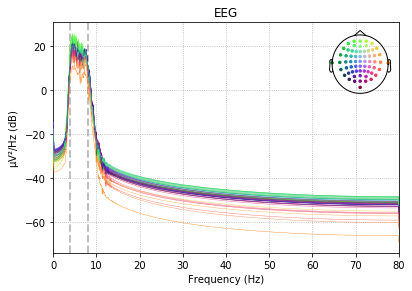

672
2000
3328
4656
5984
7312
8640
9968
11296
12624
13952
15280
16608
17936
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [6]:
low = 4
high = 8
fdata = sub.band_pass_filter(sub.data,low, high);
fdata.plot_psd();
ech = sub.segment_epochs(fdata)


In [7]:
sub.events

array([[  672,     0,     2],
       [ 2000,     0,     1],
       [ 3328,     0,     1],
       [ 4656,     0,     2],
       [ 5984,     0,     2],
       [ 7312,     0,     1],
       [ 8640,     0,     1],
       [ 9968,     0,     2],
       [11296,     0,     1],
       [12624,     0,     2],
       [13952,     0,     2],
       [15280,     0,     1],
       [16608,     0,     1],
       [17936,     0,     2]])

Loading data for 7 events and 321 original time points ...
0 bad epochs dropped
Loading data for 7 events and 321 original time points ...
Loading data for 7 events and 321 original time points ...


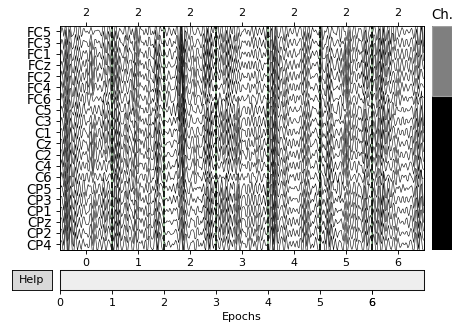

In [8]:
ech['T2'].plot();

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


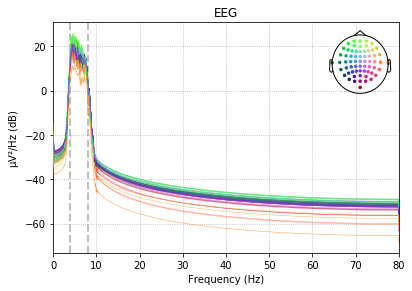

In [9]:
low = 1;
high = 8;
fdata = sub.band_pass_filter(sub.data,low, high)
fdata.plot_psd();


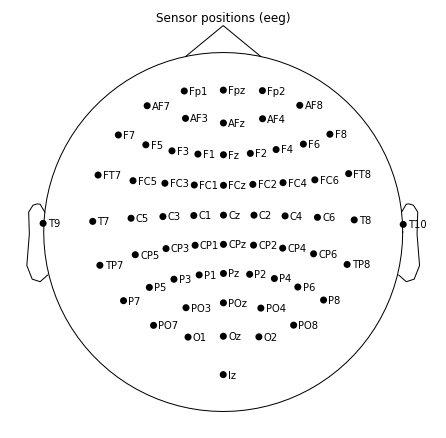

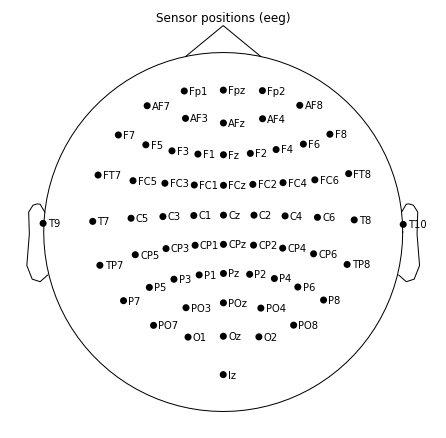

In [10]:
fdata.plot_sensors(ch_type='eeg', show_names = True)

001
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


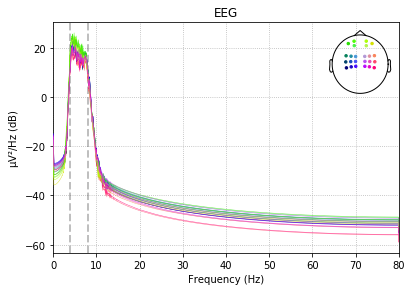

672
2000
3328
4656
5984
7312
8640
9968
11296
12624
13952
15280
16608
17936
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S001/S001R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


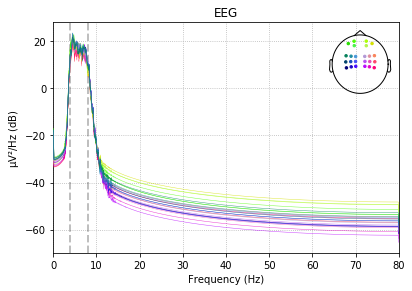

672
2000
3328
4656
5984
7312
8640
9968
11296
12624
13952
15280
16608
17936
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S001/S001R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


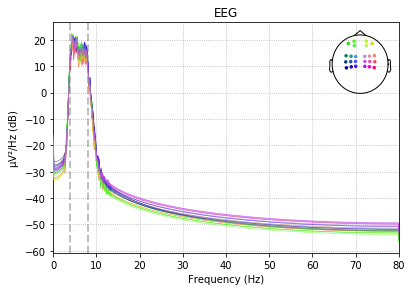

672
2000
3328
4656
5984
7312
8640
9968
11296
12624
13952
15280
16608
17936
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
002
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S002/S002R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


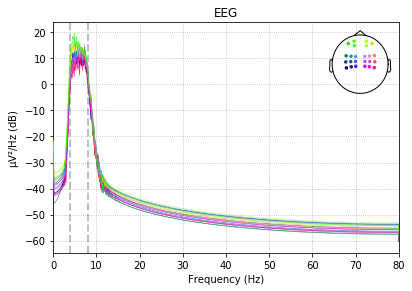

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S002/S002R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


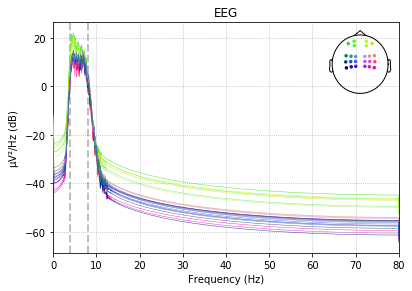

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S002/S002R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


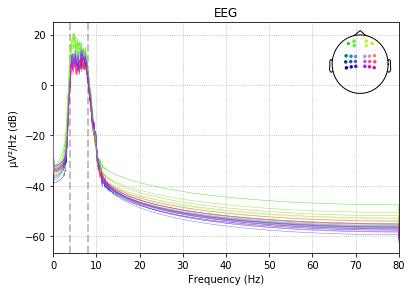

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
003
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S003/S003R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


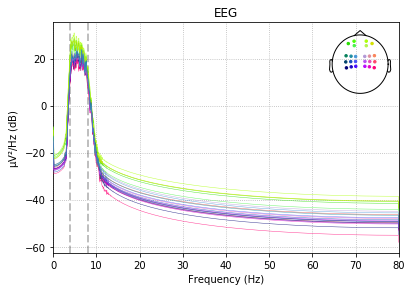

672
2000
3328
4656
5984
7312
8640
9968
11296
12624
13952
15280
16608
17936
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S003/S003R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


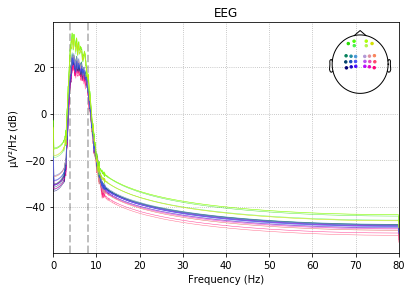

672
2000
3328
4656
5984
7312
8640
9968
11296
12624
13952
15280
16608
17936
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S003/S003R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


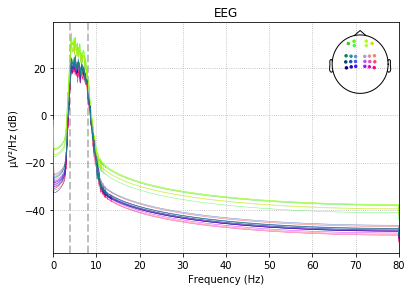

672
2000
3328
4656
5984
7312
8640
9968
11296
12624
13952
15280
16608
17936
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
004
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S004/S004R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


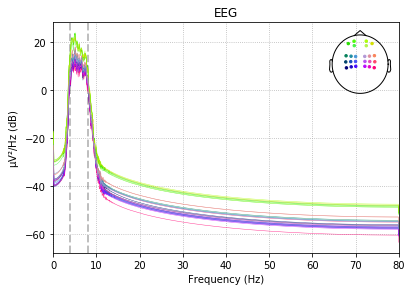

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S004/S004R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


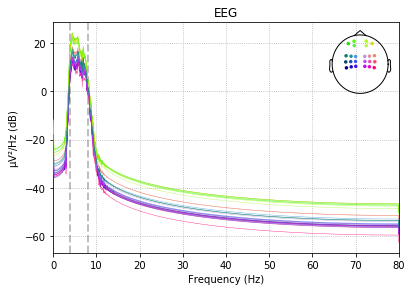

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S004/S004R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


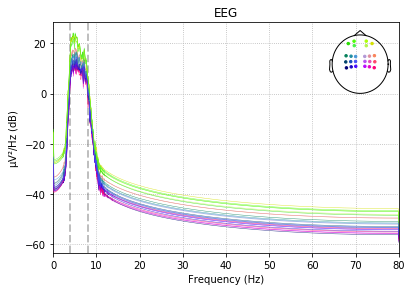

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
005
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S005/S005R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


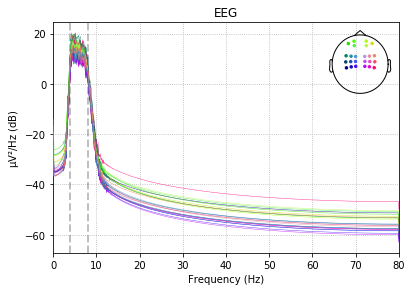

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S005/S005R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


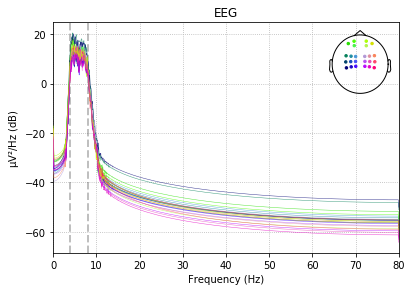

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S005/S005R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


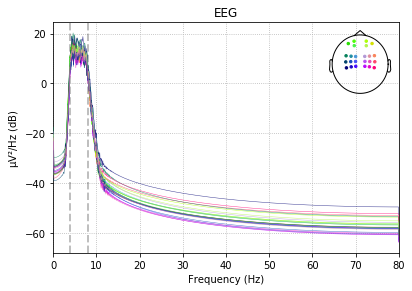

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
006
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S006/S006R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


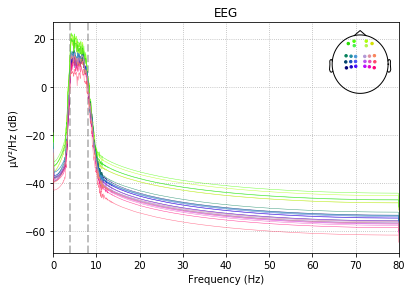

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S006/S006R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


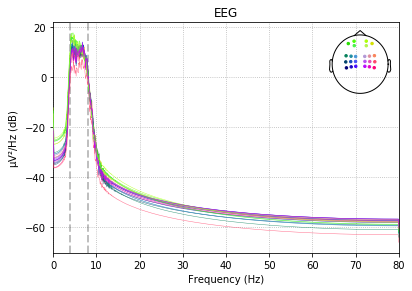

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S006/S006R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


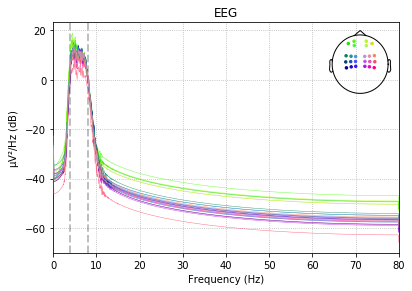

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
007
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S007/S007R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


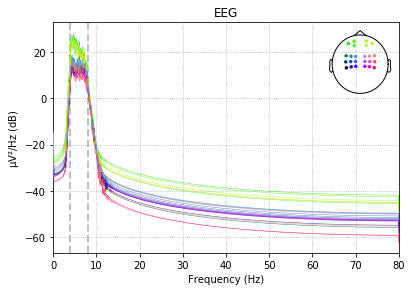

672
2000
3328
4656
5984
7312
8640
9968
11296
12624
13952
15280
16608
17936
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S007/S007R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


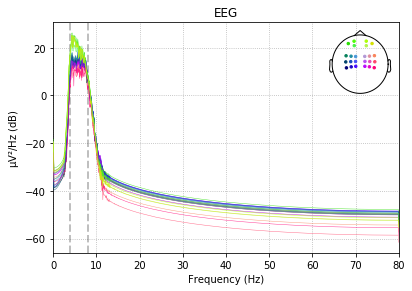

672
2000
3328
4656
5984
7312
8640
9968
11296
12624
13952
15280
16608
17936
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S007/S007R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


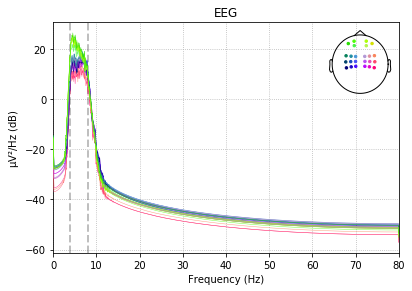

672
2000
3328
4656
5984
7312
8640
9968
11296
12624
13952
15280
16608
17936
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
008
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S008/S008R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


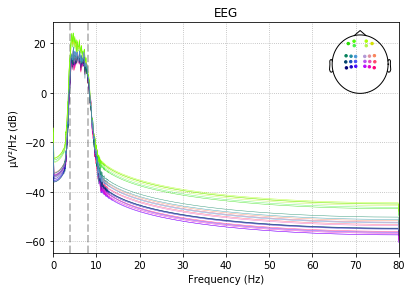

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S008/S008R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


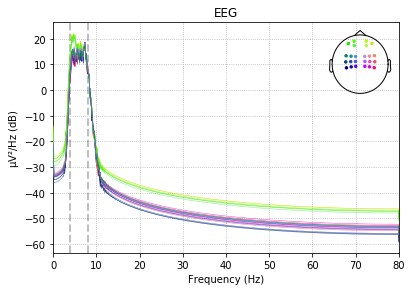

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S008/S008R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


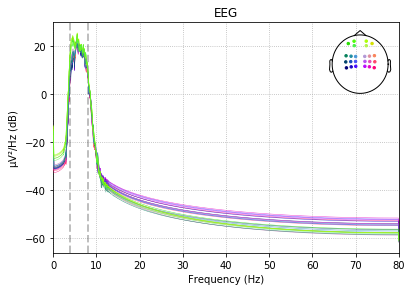

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
009
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S009/S009R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


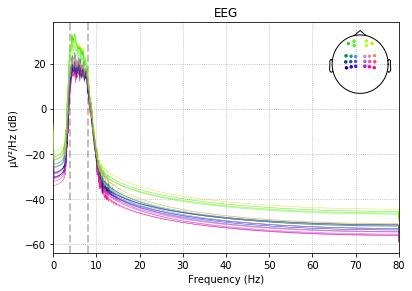

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S009/S009R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


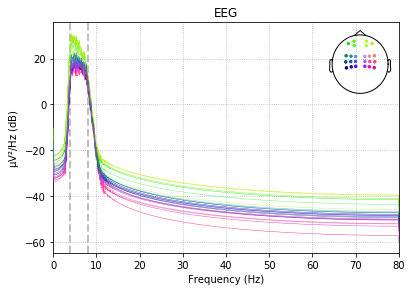

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S009/S009R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


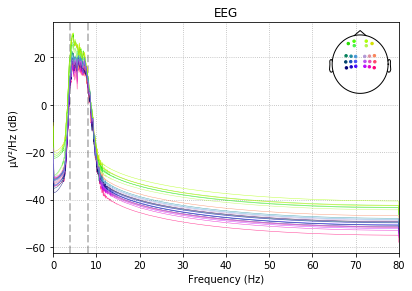

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
010
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S010/S010R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


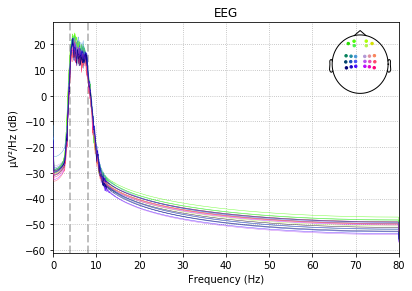

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S010/S010R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


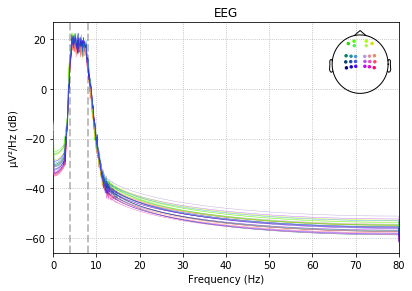

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Extracting EDF parameters from /media/biraj/DATA/Motor Imagery Dataset/S010/S010R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Effective window size : 12.800 (s)


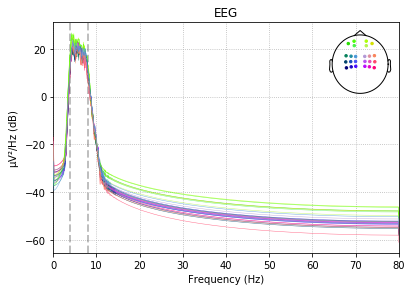

656
1968
3280
4592
5904
7216
8528
9840
11152
12464
13776
15088
16400
17712
Used Annotations descriptions: ['T1', 'T2']
14 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [12]:
low = 4;
high = 8;

epochs_list = [];

for i in range(10):
    i+= 1;
    sbj=str(i);
    if i<10:
        sbj='00'+str(i); print(sbj)
    elif ((i>=10) and (i<100)):
        sbj='0'+str(i); print(sbj)
    for j in [3, 7, 11]:
        if j<=2:
             continue
        rec=str(j);
        if((j>=3) and (j<10)):
            rec='0'+str(j);
        sub=subject(sbj,rec);
        #sub.info
        fdata = sub.band_pass_filter(sub.data,low, high);
        fdata.plot_psd();
        epochs_list.append(sub.segment_epochs(fdata))
        
        

In [13]:
theta_T1 = []
theta_T2 = []
for i in epochs_list:
    theta_T1.append(i['T1'].get_data())
    theta_T2.append(i['T2'].get_data())

Loading data for 7 events and 321 original time points ...
0 bad epochs dropped
Loading data for 7 events and 321 original time points ...
0 bad epochs dropped
Loading data for 7 events and 321 original time points ...
0 bad epochs dropped
Loading data for 7 events and 321 original time points ...
0 bad epochs dropped
Loading data for 7 events and 321 original time points ...
0 bad epochs dropped
Loading data for 7 events and 321 original time points ...
0 bad epochs dropped
Loading data for 7 events and 321 original time points ...
0 bad epochs dropped
Loading data for 7 events and 321 original time points ...
0 bad epochs dropped
Loading data for 7 events and 321 original time points ...
0 bad epochs dropped
Loading data for 7 events and 321 original time points ...
0 bad epochs dropped
Loading data for 7 events and 321 original time points ...
0 bad epochs dropped
Loading data for 7 events and 321 original time points ...
0 bad epochs dropped
Loading data for 7 events and 321 origin

In [14]:
x = np.array(theta_T1)
print(x.shape)

theta_RT1 = x.reshape(x.shape[0]*x.shape[1],24,321)
print(theta_RT1.shape)

(30, 7, 24, 321)
(210, 24, 321)


In [ ]:
low = 4;
high = 8;

epochs_list = [];

for i in range(10):
    i+= 1;
    sbj=str(i);
    if i<10:
        sbj='00'+str(i); print(sbj)
    elif ((i>=10) and (i<100)):
        sbj='0'+str(i); print(sbj)
    for j in [4, 7, 12]:
        if j<=2:
             continue
        rec=str(j);
        if((j>=3) and (j<10)):
            rec='0'+str(j);
        sub=subject(sbj,rec);
        #sub.info
        fdata = sub.band_pass_filter(sub.data,low, high);
        fdata.plot_psd();
        epochs_list.append(sub.segment_epochs(fdata))
        

In [ ]:
theta_IT1 = []
theta_IT2 = []
for i in epochs_list:
    theta_IT1.append(i['T1'].get_data())
    theta_IT2.append(i['T2'].get_data())

In [17]:
x = np.array(theta_IT1)
print(x.shape)

theta_IT1= x.reshape(x.shape[0]*x.shape[1],24,321)
print(theta_IT1.shape)

(30, 7, 24, 321)
(210, 24, 321)


In [26]:
import scipy.signal as sig
import cmath

In [27]:
theta_RT1[1,1].shape

(321,)

In [28]:
plv_RT1 = np.zeros((210,24,24,321));
plv_IT1 = np.zeros((210,24,24,321));
count = 0;
c = 0-1j;
for ik in range(210):
    for jk in range(24):
        for kk in range(jk):
            #print(ik,kk);
            inst_phasediff = np.unwrap(np.angle(sig.hilbert(theta_RT1[ik,jk])))-np.unwrap(np.angle(sig.hilbert(theta_RT1[ik,kk])));
            plv_RT1[ik,jk,kk,:] = np.exp(np.imag(inst_phasediff*c))
            
            inst_phasediff = np.unwrap(np.angle(sig.hilbert(theta_IT1[ik,jk])))-np.unwrap(np.angle(sig.hilbert(theta_IT1[ik,kk])));
            plv_IT1[ik,jk,kk,:] = np.exp(np.imag(inst_phasediff*c))
            count+=1;

In [29]:
plv_RT1 = np.absolute(plv_RT1/count)
plv_IT1 = np.absolute(plv_IT1/count)

In [30]:
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh

In [31]:
a,b= largest_eigsh(np.absolute(plv_RT1[i,:,:,j]),k=1, which = 'LM')
b.shape

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [24]:
evc_RT1 = np.zeros((210,24,321));
evc_IT1 = np.zeros((210,24,321))
for ik in range(210):
    for jk in range(321):
        a,b = largest_eigsh(np.absolute(plv_RT1[ik,:,:,jk]),k=1, which='LM');
        evc_RT1[ik,:,jk] = np.squeeze(b);
        a,b = largest_eigsh(np.absolute(plv_IT1[ik,:,:,jk]),k=1, which='LM');
        evc_IT1[ik,:,jk] = np.squeeze(b);

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(evc_IT1[22,:,:], aspect = 'auto')